## This file contains one commented process of loading, preparing and splitting one dataset and creating, training and evaluating one model.

### More training with different hyperparameters in other files.

In [1]:
from imports import *

2024-06-23 16:37:03.808440: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 16:37:03.831154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 16:37:03.831173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 16:37:03.831190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 16:37:03.835776: I tensorflow/core/platform/cpu_feature_g

In [2]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
from load_data import DataLoader
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()
data_loader = DataLoader()

## 0. Data loading

This file works with forex EURUSD currency pair with candles measured every 15 minutes.

In [3]:
data, pip_factor= data_loader.load_eurusd_15min()

In [4]:
data.head()

,time,open,high,low,close,volume
49999,2022-05-04 07:30,1.05122,1.05267,1.05108,1.05240,3774
50000,2022-05-04 07:45,1.05241,1.05267,1.05204,1.05240,3192
50001,2022-05-04 08:00,1.05241,1.05282,1.05186,1.05239,2919
50002,2022-05-04 08:15,1.05241,1.05266,1.05170,1.05246,3713
50003,2022-05-04 08:30,1.05246,1.05328,1.05240,1.05285,2757


## 1. Data preparation

Model will be trained on input sequences of length 32 (eight hours) and target sequences of length 8 (two hours)

In [5]:
input_seq_len = 32
output_seq_len = 8

# 60:20:20 split for training validation test sets
train_pct = 0.6
val_pct = 0.2

1.a Replace prices with their filtered versions

In [6]:
b, a = butter(5, 1/8, btype='low', analog=False)
data['bw_open'] = filtfilt(b, a, data['open'])
data['bw_high'] = filtfilt(b, a, data['high'])
data['bw_low'] = filtfilt(b, a, data['low'])
data['bw_close'] = filtfilt(b, a, data['close'])

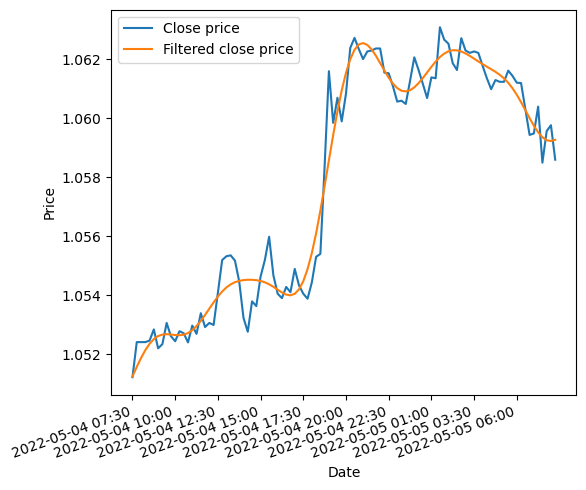

In [7]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)

ax1.plot(data['time'][:100], data['open'][:100], label='Close price')
ax1.plot(data['time'][:100], data['bw_open'][:100], label='Filtered close price')

every_nth = 10
xticks = data['time'][:100:every_nth]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=20, ha='right');
ax1.legend()
ax1.set_ylabel('Price')
ax1.set_xlabel('Date');

Note: Although model's target sequences will be made of the filtered price instead of the original price, the evaluation will be computed with the original (so the evaluation is done on real-world data).

1.b Add technical indicators: Relative Strength Index, Williams %R

In [8]:
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='close')

In [9]:
data.dropna(how='any', axis=0, inplace=True)

In [10]:
list(data.columns)

['time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'bw_open',
 'bw_high',
 'bw_low',
 'bw_close',
 'rsi_close_14',
 'willr_close_42']

In [11]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42'])

In [12]:
# save data for future evaluation
target_time = data[['time', 'bw_close', 'close']]

Instead of price, use movement of price from one candle to following one

In [13]:
data = data_processor.diff_features(data, ['close', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])

In [14]:
min(data['bw_close']), max(data['bw_close']), np.median(data['bw_close'])

(-0.0019105034263933174, 0.002587228233668304, 2.1907770604290278e-06)

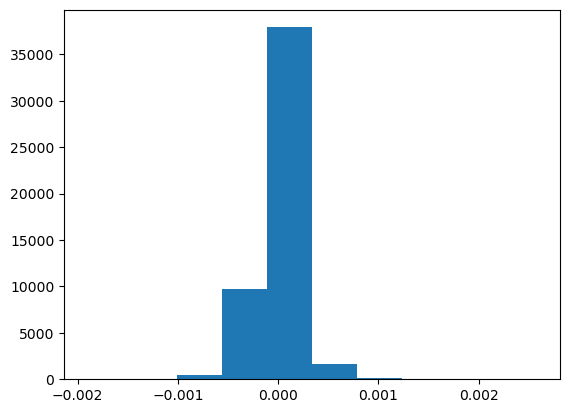

In [15]:
# what values are we curently working with?
plt.hist(data['bw_close']);

To prevent from having all values this close to zero, use pips instead of movement of price.

In [16]:
data.loc[:, 'close'] *= pip_factor
data.loc[:, 'bw_close'] *= pip_factor
data.loc[:, 'bw_open'] *= pip_factor
data.loc[:, 'bw_high'] *= pip_factor
data.loc[:, 'bw_low'] *= pip_factor

In [17]:
# save transformed data for future evaluation
target = data[['close', 'bw_close']]

In [18]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

/tmp/ipykernel_40595/4177561520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)


## 2. Split data

In [20]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [21]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [22]:
# discard time column
Xtrain = (Xtrain_time[:, :, 1:]).astype(np.float64)
Xval = (Xval_time[:, :, 1:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 1:]).astype(np.float64)

ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [23]:
# parameters of the transformer model
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': ytrain.shape[-1],
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [25]:
epochs = 2

path = 'saved_models/tf-thesis.h5'

#model = model_trainer.load_model_transformer(path, Xtest, config)

model = Transformer(config)

In [ ]:
model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'str'> <class 'int'> <class 'vanilla_transformer.Transformer'> <class 'float'> <class 'dict'> <class 'numpy.ndarray'>


2024-06-23 16:40:21.514032: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557767e5d260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-23 16:40:21.514049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-23 16:40:21.521157: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-23 16:40:21.964455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2024-06-23 16:40:22.038503: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
